# Neural Style Transfer CNNs
By David Tarazi and Dieter Brehm, October 2019

## Introduction
We utilized different layers within the pre-trained VGG19 CNN to transfer the style of one image into another. We also wanted to see what different ways we could compute the loss to see if we could vary the results in some pattern if possible. This notebook dives into our process for acheiving style transfer.

## Setup
Import libraries and a local utility script for the sake of shortening and simplifying the code shown in this report notebook.

In [5]:
import MLUtility as util
import tensorflow as tf
# With tf v1.14, you should use tfp v0.7
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if tf.__version__ != "1.14.0":
    print("Warning, tensorflow version not compatible with this notebook")
    
import warnings
warnings.filterwarnings('ignore')

In [6]:
# show live results if running TF -> 1.14
tf.enable_eager_execution()

In [7]:
# download two test images
#content_path = tf.keras.utils.get_file('olin.jpg','https://github.com/Inkering/ML-Project-1/blob/master/71934026_761426527628858_7267766954746707968_n.png?raw=true')
#style_path = tf.keras.utils.get_file('painting.jpg','https://github.com/Inkering/ML-Project-1/raw/master/StarryNight.jpg')
content_path = "Data/olin.png"
style_path = "Data/sunset.jpg"

## Looking at the two inputs
Quickly visualize the two images we will applying filters onto, i.e. the style image we will be getting style information from and the content image we will be applying a generated convolution filter onto to make it look like the style of the style image. For now, we'll look at the two unmodified inputs.

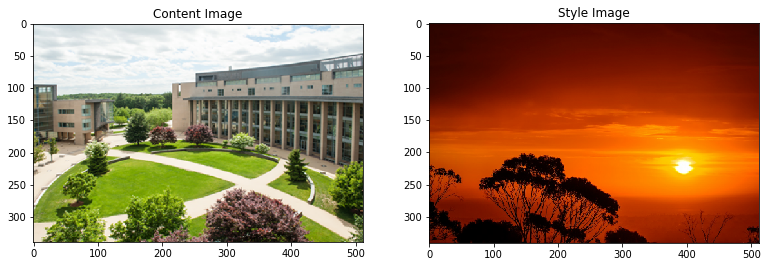

In [8]:
content_image = util.transform_image(content_path, 512)
style_image = util.transform_image(style_path, 512)
fig = plt.gcf()
fig.set_size_inches(13,8)
plt.subplot(1, 2, 1)
util.imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
util.imshow(style_image, 'Style Image')

## Let Keras preprocess the input to fit desired dimensionality
Next, we'll use Keras to preprocess the input image to work with the vgg model we will transfer learning with. The process involves scaling it into a square and increasing the pixel values.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


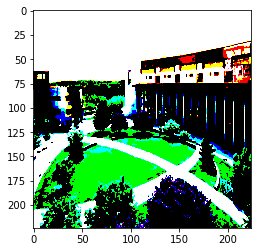

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*200)
x = tf.image.resize(x, (224, 224))
util.imshow(x)

## (Cool) What does the VGG model think the input looks like?
We can quickly run a classification on the input, after all, that is what vgg is actually for despite the fact that we are essentially intercepting the intermediary layers before a squashing and classification occurs. It is interesting to see what it thinks the olin O is though!

In [10]:
# download Keras
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
# show the top 5 predictions for what the content image is
predicted = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted]

[('palace', 0.27103126),
 ('monastery', 0.121630244),
 ('patio', 0.0721746),
 ('mosque', 0.065551676),
 ('sundial', 0.033055462)]

## Implementing transfer learning and style content loss
**A note on how the loss function works in this implementation**:  
Basically, the content loss function is calculating the sum of the mean squared
error between the generated image and the content image. The activations in the
higher layers of the generated image often represent objects shown in the
image. So the content loss function focuses on the higher layers correlated
specifically to objects or content.

On the other hand, the style loss function looks at all of the layers in the
CNN. style information is measured as the amount of correlation present between
features maps in a given layer. Next, a loss is defined as the difference of
correlation present between the feature maps computed by the generated image and
the style image. Our implementation is shown below, but **Don't run it**, as it is a snippet taken from the utilities script and several variables won't be defined in this context.

In [23]:
# Don't run this! It's setup to be run from the MLUtility module import and won't work great without it.
def style_content_loss(self, outputs):
    """
    Finding the loss for both style and content by comparing the generated image to the input image
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    return loss


First, we'll pick layers to work with for the content and style representations. As seen below, we only pick one content layer and then we pick five style layers. This is because we want the content loss to consider important features of the image as elements which should still be present after applying the style transfer. Relative to the breadth of the style layers, the content layer picked is late in the chain of layers meaning that we cosider only the fairly important features for classification when considering the content loss and what we want to keep in the end result. On the other hand, we pick quite a few style layers because we want a variety of different feature maps so that are more likely to capture what humans see as the "essense," or style of an image:

In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Then, according to idiosyncrasies of the model format, we need to create a new version of the model which involves feeding only the desired layers we wrote above of the VGG classifier network into a new model which only considers those layers. After creating this limited model compared to the massive VGG classifier system, we can apply the style image to it and get some outputs for those given layers!

In [24]:
style_model = util.vgg_2_functional_model(style_layers)
style_outputs = style_model(style_image*255)

This gives us a set of outputs, but we need a method to combine them so that we can quantitatively compare it to the content and compute a loss which we can later perform gradient descent on. One method is to use a gram matrix, which is a form of correlation matrix:

In [13]:
def gram_matrix(input_tensor):
    # Finds the correlation matrix for style loss and sums all of the feature correlations for a particular layer
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    # num_locations is the same as number of pixels
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # normalize
    return result/(num_locations)

In our utilities script, we define a shortcut class that allows us to repeatedly call a function that generates style and content outputs. It utilizes the gram matrix to combine the outputs of the style layers. It returns both that combined style output matrix and the outputs given from passing the content image through the model. Our implementation is shown below, but **Don't run it**, as it is a snippet taken from the utilities script and several variables won't be defined in this context.

In [ ]:
# Don't run this! It's just a snippet from the utilities class and won't run correctly out of that context!
def call(self, inputs, gram = True):
        """
        Overloading the keras Model call method

        Input False for gram to use the covariance matrix
        """
        # Expects float input in [0,1]
        inputs = inputs*255.0
        # depending on model - resize/process inputs to the right size, shape, etc.
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        # image layers
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Puts the style outputs into their correlation matrix form so that we can compute loss
        if gram is True:
            style_outputs = [gram_matrix(style_output)
                             for style_output in style_outputs]
        else:
            style_outputs = [covar_matrix(style_output)
                             for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [14]:
# create an instance of the class described above
model_instance = util.StyleContentModel(style_layers, content_layers)

results = model_instance.call(tf.constant(content_image))

### Visualizing a intermediary style layer
Each style layer is a tensor that holds style information as a gram matrix. We can look at a visual representation of it and examine its shape! It looks pretty patternless, but it is the pooled representation of the insides of the network, similar to the homework assignment in Machine Learning 2019 at Olin College in which looked a neural net intermediary layer set for image identification.

(1, 64, 64)
(8, 8, 64)


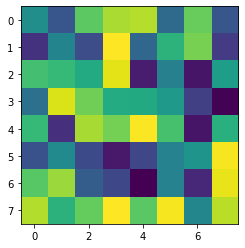

In [15]:
#pluck out a layer and convert to np array
layer_shown = results["style"]["block1_conv1"]
print(layer_shown.shape)
layer_shown = layer_shown*255
layer_shown = np.array(layer_shown, dtype=np.uint8)

#reshape to an image size
layer_shown = np.reshape(layer_shown,(8,8,64))

print(layer_shown.shape)
plt.imshow(layer_shown[:,:,0])

### Preparing the experiment
Now, we can run a gradient descent on our loss functions and get a significant style transfer output! Firstly, by setting the targets we will run our functions against.

In [16]:
# Setting the targets by pulling them out of the run model instance
style_targets = model_instance(style_image)['style']
content_targets = model_instance(content_image)['content']

# Defining the image as a tensorflow variable to make it constant
image = tf.Variable(content_image)

Defining the optimizer - it is possible to further tune the learning rate which is passed in here, but 10 appears to work fairly well.



In [17]:
opt = tf.train.AdamOptimizer(learning_rate=10)

As with all gradient descents, we need to choose a starting point

In [18]:
style_weight=1e-2
content_weight=1e4

## Running the experiment

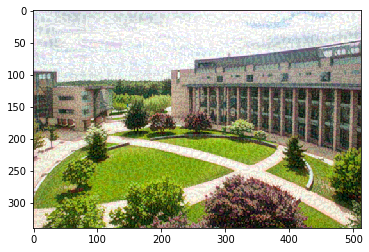

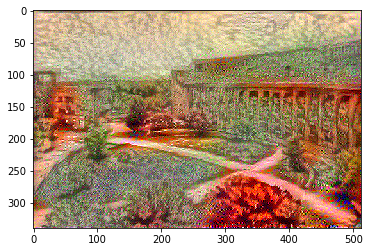

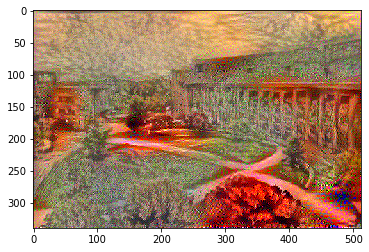

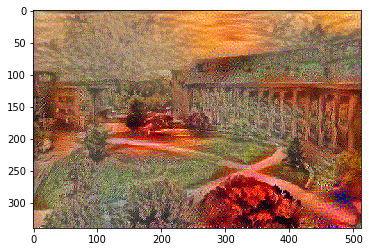

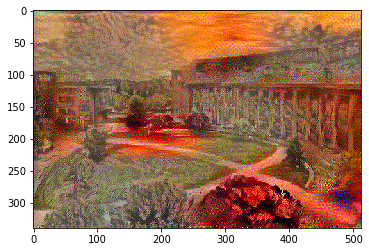

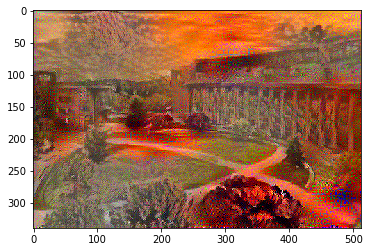

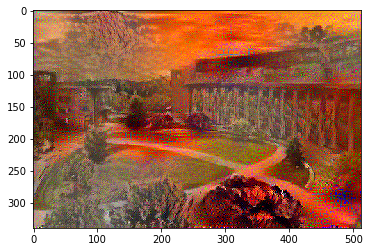

In [21]:
experiment = util.experiment_handler(content_image,
                                     model_instance,
                                     style_targets,
                                     content_targets,
                                     style_weight,
                                     content_weight,
                                     num_style_layers,
                                     num_content_layers)
experiment.run(700)

### Looking at the loss over experiment runs

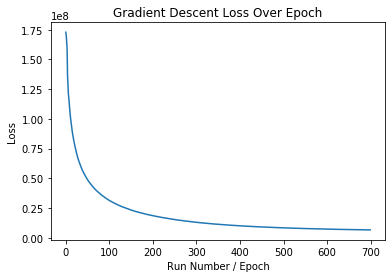

tf.Tensor(6655270.0, shape=(), dtype=float32)


In [22]:
plt.figure()
plt.plot(experiment.losses)
plt.title("Gradient Descent Loss Over Epoch")
plt.xlabel("Run Number / Epoch")
plt.ylabel("Loss")
plt.show()
print(experiment.losses[-1])

## But what happens if we try to use a covariance matrix as opposed to the gram matrix?

We create a new model instance and collect style results from the VGG19 model that were analyzed using the covariance matrix instead of the gram matrix.

In [25]:
# create an instance of the model class using the covariance matrix
model_instance_covar = util.StyleContentModel(style_layers, content_layers)

# Give the gram parameter False
results_covar = model_instance_covar.call(tf.constant(content_image), False)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


### It doesn't run, but why?
However, when we tried to run the model, we quickly learned that the style outputs using the covariance matrix were much larger than the outputs from the gram matrix. We hypothesize that similar to when doing an SVD on an [n, m] matrix, you end up with a couple of different matrices that show the correlation. One of which is an [n, n] matrix that tells you the distance between each individual sample in the matrix (covariance), while another is an [m, m] matrix that tells you the distance between the features in the matrix (gram). As a result, the gram matrix seems to hold similar content, but is much more efficient to run than a covariance matrix since it pulls out the important correlations rather than all of the correlations.

So while it is possible for this method to work, you run into resource errors when trying to take a massive tensor and find the gradient of its loss. We ran into errors before reaching one step in the gradient. Below is a comparison of the first style convolution layer's correlation matrix.

In [26]:
# show the size of the gram matrix first result layer
print("Gram matrix layer size: ")
print(layer_shown.shape)

# compute and show the size of the covariance matrix first result layer
layer_shown_covar = results_covar["style"]["block1_conv1"]
print("\nCovariance matrix layer size: ")
print(layer_shown_covar.shape)

Gram matrix layer size: 
(8, 8, 64)

Covariance matrix layer size: 
(340, 512, 64, 64)


## Below runs the failed experiment

In [ ]:
# Setting the targets
style_targets_covar = results_covar['style']
content_targets_covar = results_covar['content']

In [ ]:
experiment_covar = util.experiment_handler(content_image,
                                           model_instance_covar,
                                           style_targets_covar,
                                           content_targets_covar,
                                           style_weight,
                                           content_weight,
                                           num_style_layers,
                                           num_content_layers)
# uncomment the line below to cause error
# experiment_covar.run(10,5)